## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx, ny = 9, 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Make a list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

def generate_points(cal_images):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret is True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

def calibrate_camera(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, matrix, distortion, rotation_vecs, translation_vecs = \
        cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return matrix, distortion

In [2]:
objpoints, imgpoints = generate_points(cal_images)

In [3]:
def cal_undistort(img, matrix, distortion):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, matrix, distortion, None, matrix)
    return undist

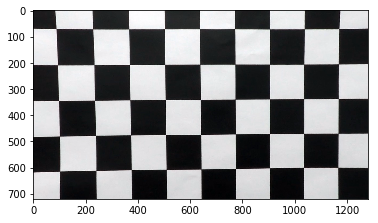

In [65]:
def test_cal(img):
    matrix, distortion = calibrate_camera(img, objpoints, imgpoints)
    undist = cal_undistort(img, matrix, distortion)
    plt.imshow(undist)
    plt.show()
    mpimg.imsave('output_images/camera_cal_test1.jpg', undist, format='jpg')
    
test_cal(cv2.imread('camera_cal/calibration1.jpg'))

## Set up display helper

In [4]:
# A helper to display input/output images side-by-side.

def display(image1, image2, label1, label2, figsize=(16, 8), cmap=None):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap=cmap)
    plt.xlabel(label1)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap=cmap)
    plt.xlabel(label2)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Get distortion corrected images

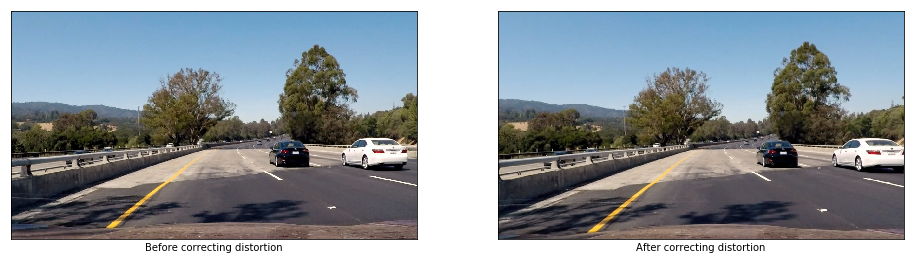

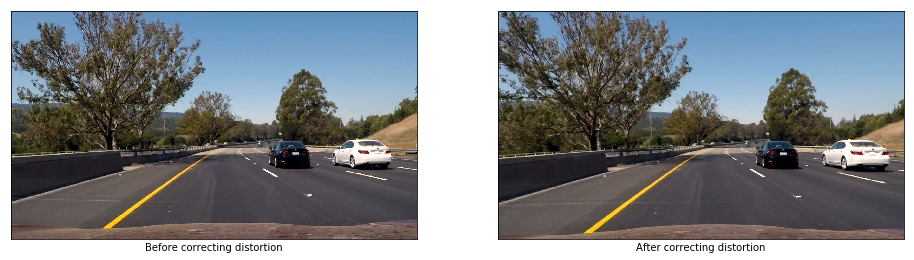

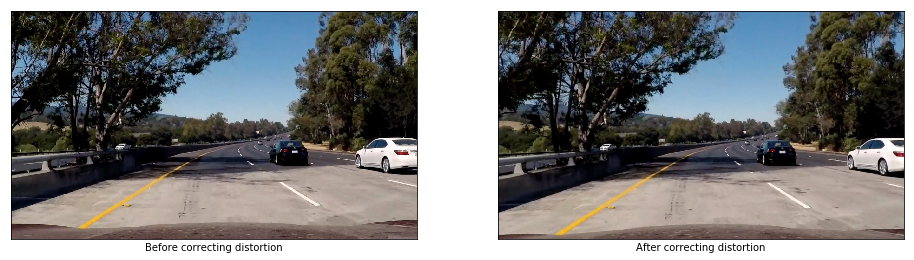

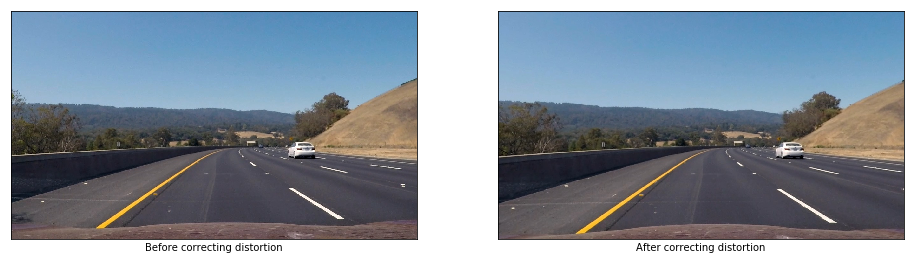

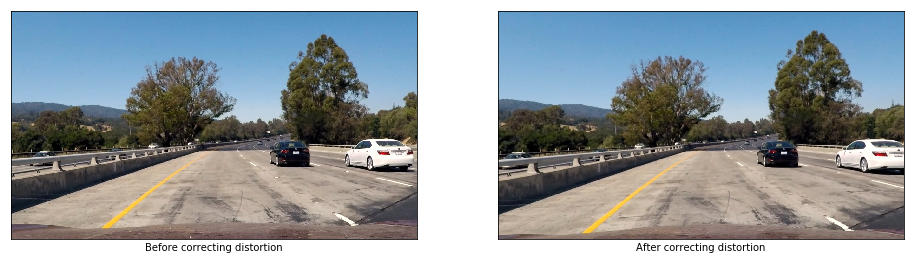

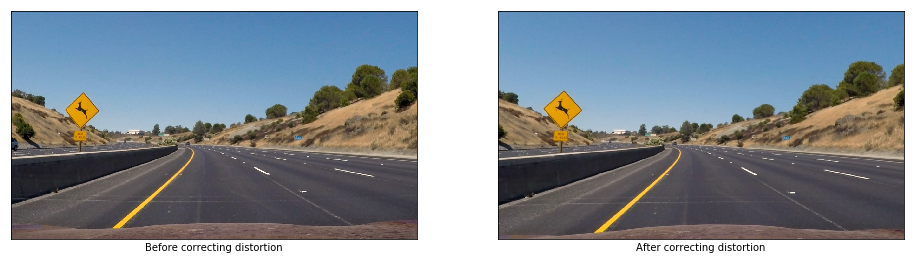

In [66]:
undistorted_images = []

test_images = glob.glob('test_images/test*.jpg')

for fname in test_images:
    img = cv2.imread(fname)
    
    matrix, distortion = calibrate_camera(img, objpoints, imgpoints)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = cal_undistort(img, matrix, distortion)
    undistorted_images.append(undist)
    display(img, undist, 'Before correcting distortion', 'After correcting distortion')
    
mpimg.imsave('output_images/undistort_test.jpg', undistorted_images[0], format='jpg')

## Thresholding

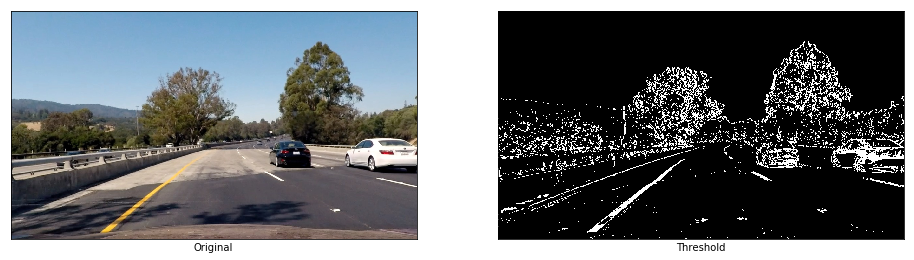

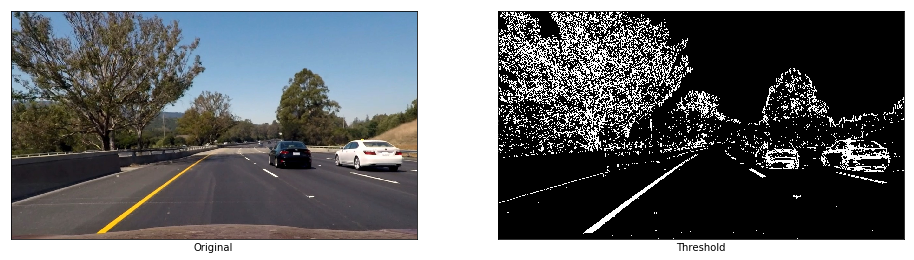

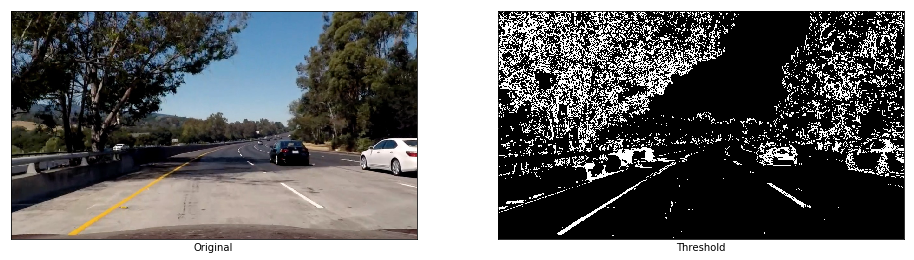

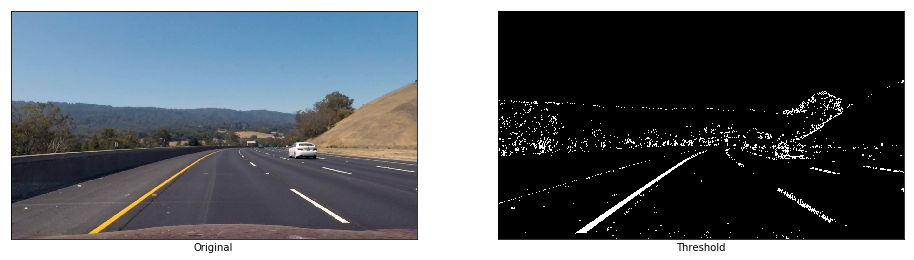

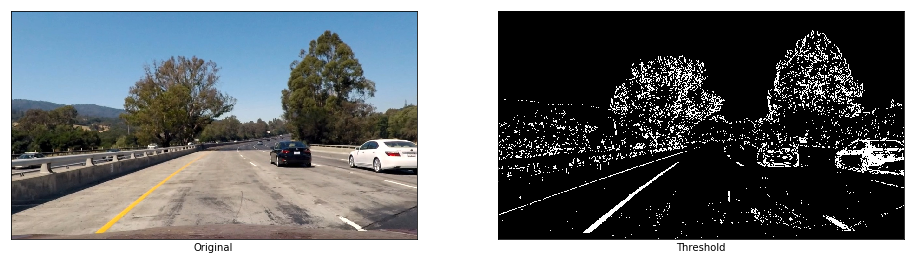

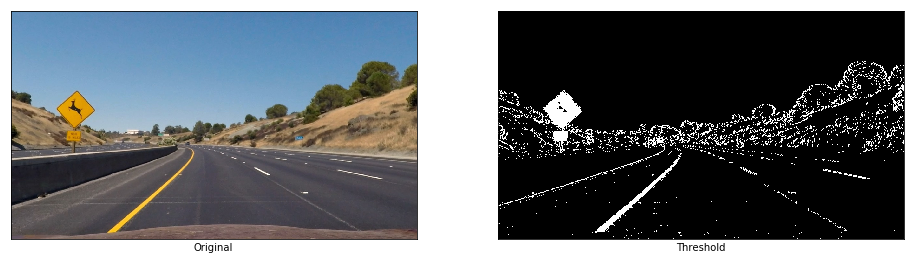

In [67]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


threshold_images = []

for img in undistorted_images:
    threshold_image = apply_threshold(img)
    threshold_images.append(threshold_image)
    display(img, threshold_image, "Original", "Threshold", cmap='gray')
    
mpimg.imsave('output_images/threshold_test.jpg', threshold_images[0], format='jpg')

## Perspective transformation

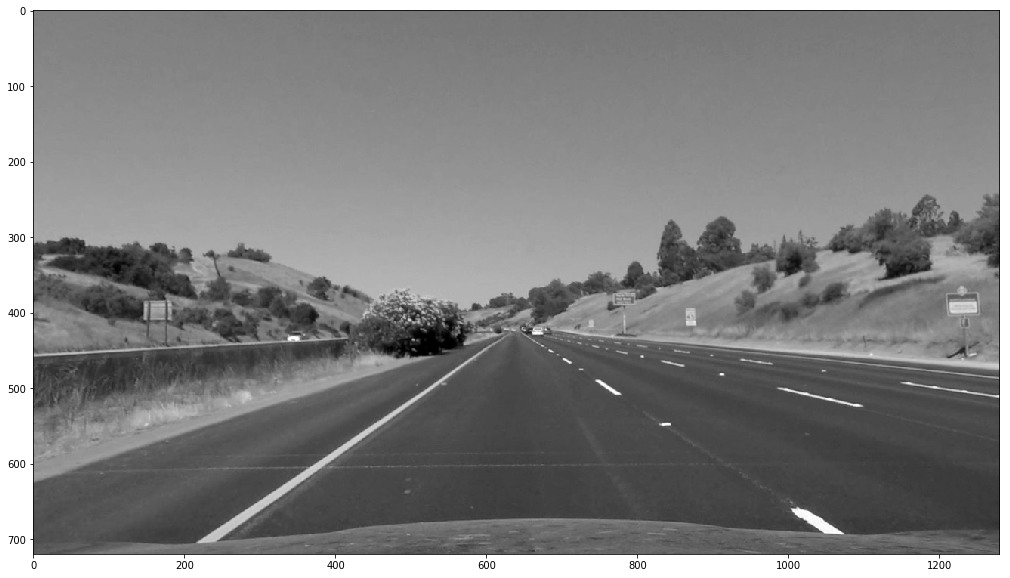

In [7]:
def helper_find_location():
    straight_lane_img = cv2.imread("test_images/straight_lines1.jpg")
    undist = cv2.undistort(straight_lane_img, matrix, distortion, None, matrix)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(20, 10))
    plt.imshow(undist, cmap='gray')
    plt.show()
    return undist
    
undist_straight_lane_gray_img = helper_find_location()

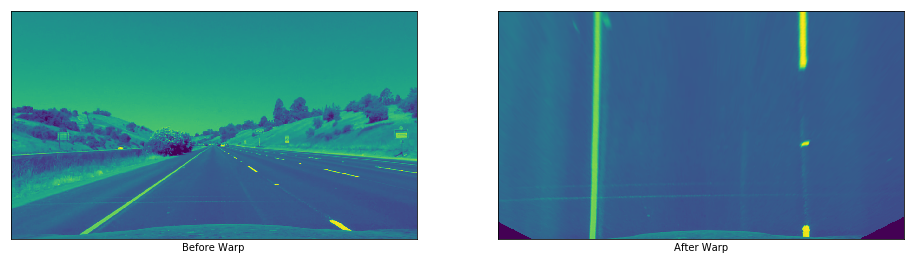

In [70]:
def warp(undistort_gray_image, mtx, dist):
    img = undistort_gray_image
    img_size = (img.shape[1], img.shape[0])
    yoffset = 100
    xoffset = 270
    
    src = np.float32([
        [510, 500],
        [780, 500],
        [1120, 700],
        [200, 700],
    ])
    dst = np.float32([
        [xoffset, yoffset],
        [img_size[0] - xoffset, yoffset],
        [img_size[0] - xoffset, img_size[1]],
        [xoffset, img_size[1]],
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv

undist_straight_lane_wraped_img, Minv = warp(undist_straight_lane_gray_img, matrix, distortion)
display(undist_straight_lane_gray_img, undist_straight_lane_wraped_img, "Before Warp", "After Warp")

In [73]:
mpimg.imsave('output_images/warp_test.jpg', undist_straight_lane_wraped_img, format='jpg')

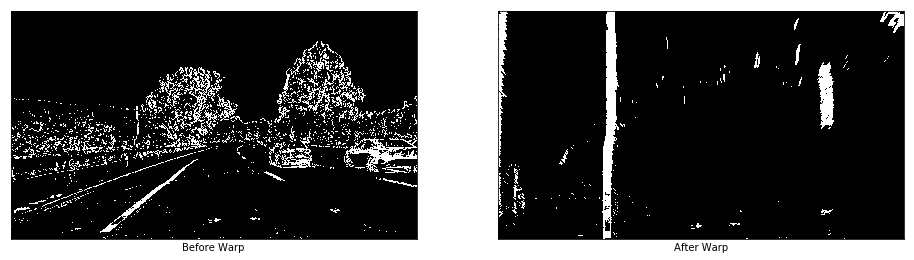

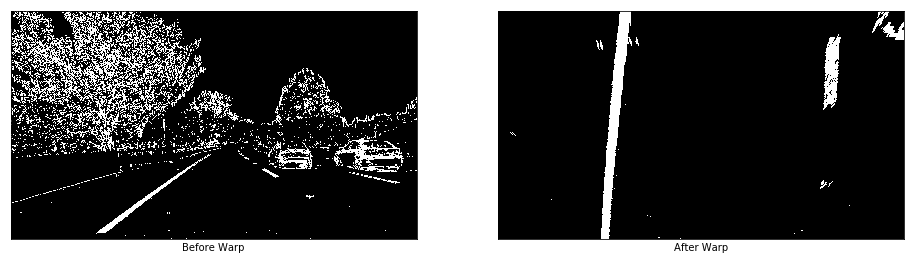

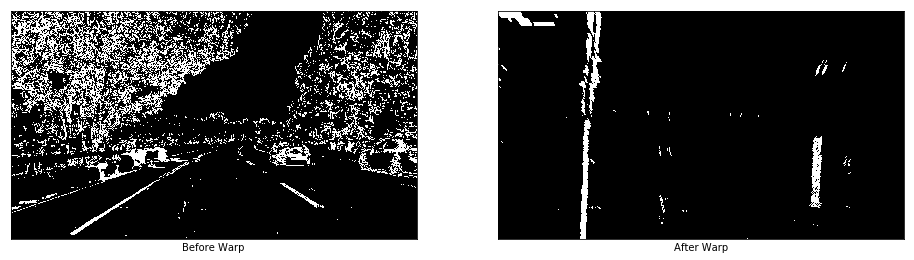

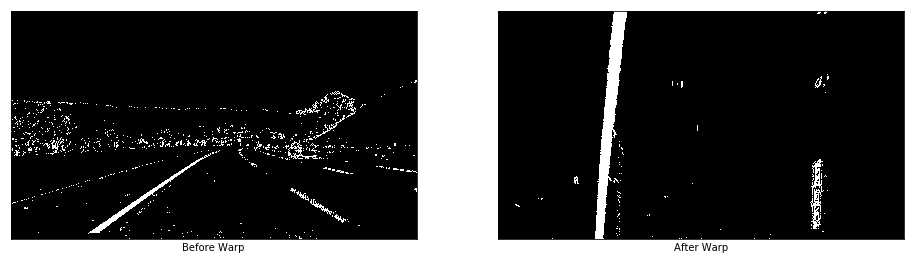

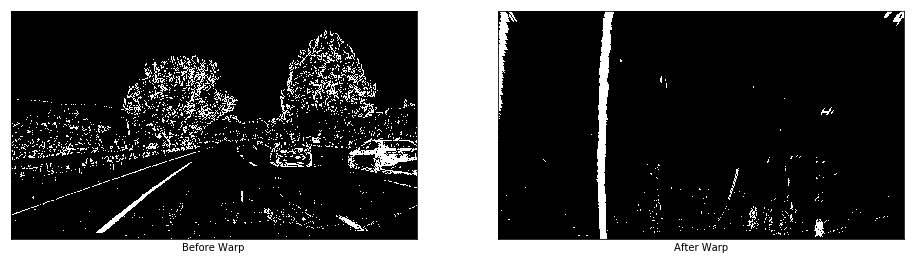

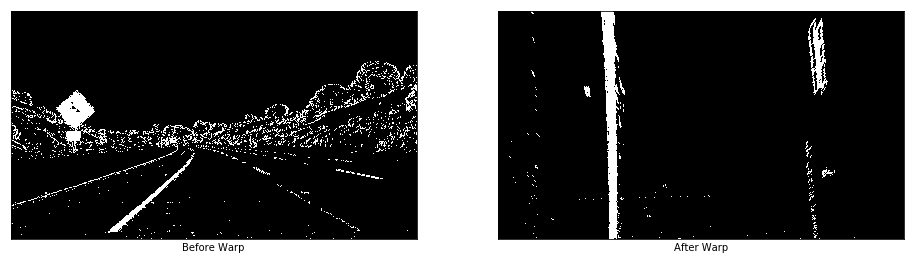

In [9]:
binary_warped_images = []

for img in threshold_images:
    warped, Minv = warp(img, matrix, distortion)
    binary_warped_images.append(warped)
    display(img, warped, 'Before Warp', 'After Warp', cmap='gray')

## Sliding Window Search and Polynomial Fitting

In [43]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 25
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
        (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
        (win_xright_high, win_y_high), (0, 255, 0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = \
        find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

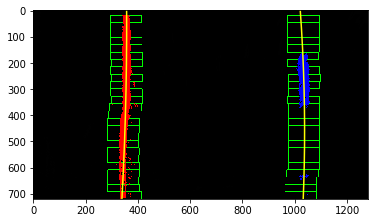

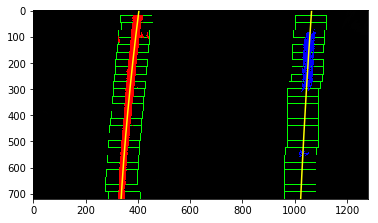

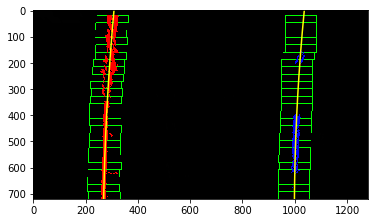

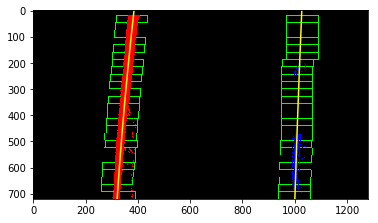

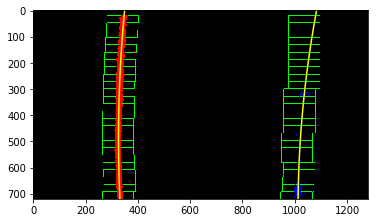

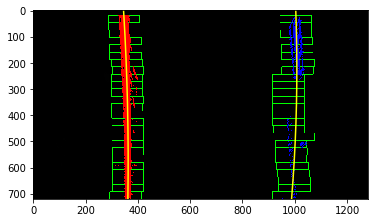

In [11]:
for binary_warp in binary_warped_images:
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = fit_polynomial(binary_warp)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warp.shape[0] - 1, binary_warp.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)
    plt.show()

## Lane Finding

In [53]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + 
                    left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + 
                    right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(lefty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds

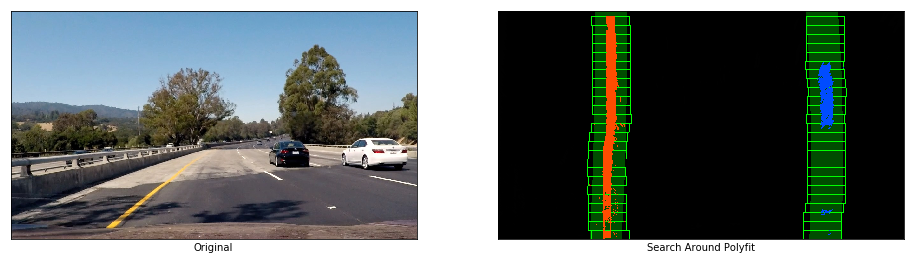

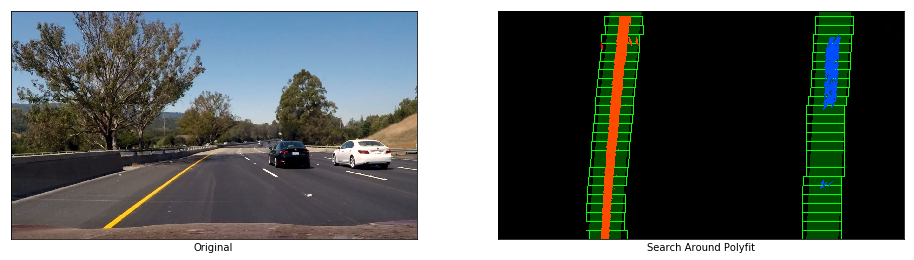

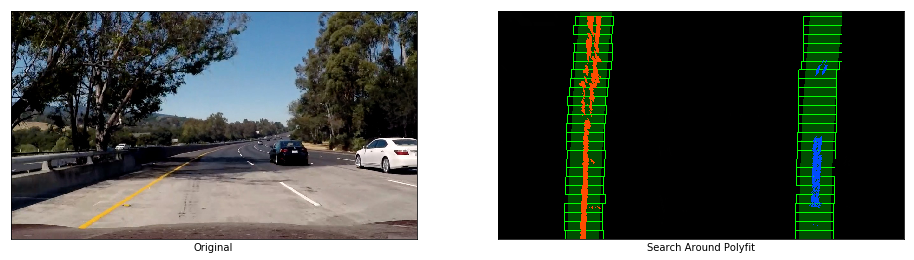

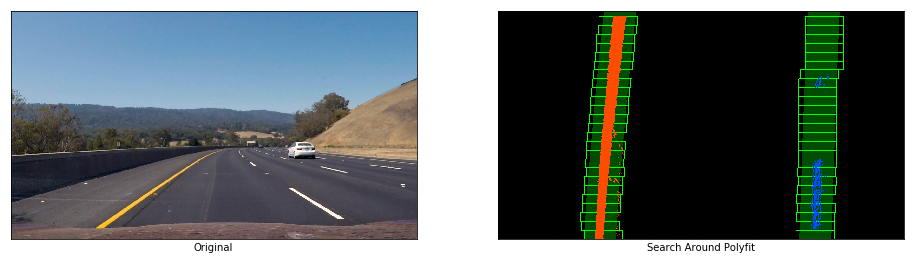

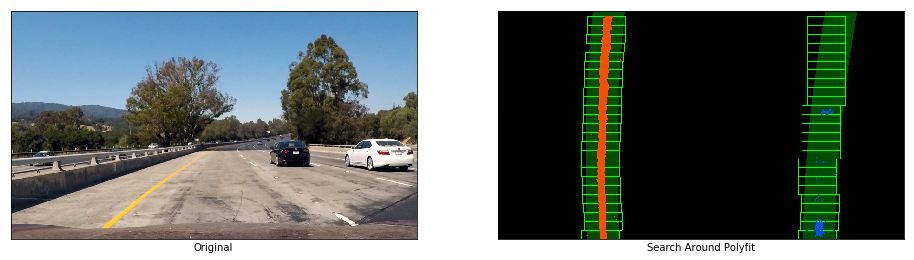

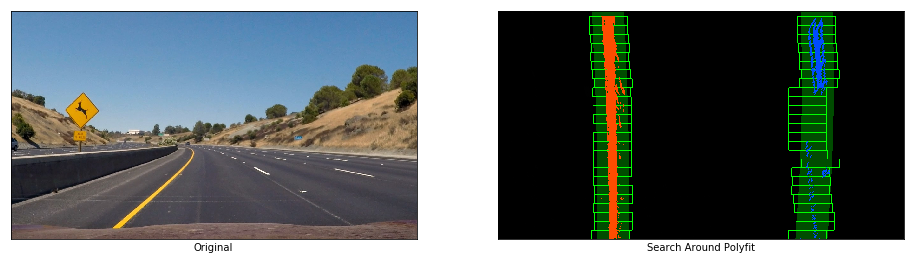

In [54]:
test_images_RGB = []

for fname in test_images:
    test_images_RGB.append(
        cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    )
    
for original, img in zip(test_images_RGB, binary_warped_images):
    margin = 50
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = fit_polynomial(img)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = search_around_poly(img, left_fit, right_fit)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    left_fitx2 = left_fit2[0] * ploty ** 2 + left_fit2[1] * ploty + left_fit2[2]
    right_fitx2 = right_fit2[0] * ploty ** 2 + right_fit2[1] * ploty + right_fit2[2]
    
    window_img = np.zeros_like(out_img)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    display(original, result, 'Original', 'Search Around Polyfit')

## Measure Curvature

In [13]:
def measure_curvature_real(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048 / 180 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    left_fit_cr, right_fit_cr, center_dist = 0, 0, 0
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    h = img.shape[0]
    ploty = np.linspace(0, h - 1, h)
    y_eval = np.max(ploty)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) \
                      ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) \
                       ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 

    if left_fit is not None and right_fit is not None:
        car_position = img.shape[1] / 2
        
        l_fit_x_int = left_fit[0] * h ** 2 + left_fit[1] * h + left_fit[2]
        r_fit_x_int = right_fit[0] * h ** 2 + right_fit[1] * h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) / 2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

In [14]:
def test_curvature():
    binary_warp = binary_warped_images[0]
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = fit_polynomial(binary_warp)
    left_curverad, right_curverad, center_dist = measure_curvature_real(
        binary_warp, left_fit, right_fit, left_lane_inds, right_lane_inds,
    )
    print("Left curvature: ", left_curverad, "m")
    print("Right curvature: ", right_curverad, "m")
    print("Distance from center: ", center_dist, "m")
    
test_curvature()

Left curvature:  654.194127976 m
Right curvature:  348.538584918 m
Distance from center:  -0.241696505663 m


## Visual display of the Lane Boundaries and Texts

In [15]:
def draw(original_img, binary_img, l_fit, r_fit, Minv):
    if l_fit is None or r_fit is None:
        return original_img
    
    new_img = np.copy(original_img)
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h, w = binary_img.shape
    ploty = np.linspace(0, h - 1, num=h)
    
    left_fitx = l_fit[0] * ploty ** 2 + l_fit[1] * ploty + l_fit[2]
    right_fitx = r_fit[0] * ploty ** 2 + r_fit[1] * ploty + r_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 255, 255), thickness=15)
    
    new_warp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    result = cv2.addWeighted(new_img, 1, new_warp, 0.5, 0)
    return result

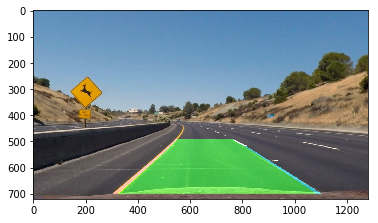

In [16]:
def test_draw():
    binary_warp = binary_warped_images[-1]
    original = undistorted_images[-1]
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = fit_polynomial(binary_warp)
    result = draw(original, binary_warp, left_fit, right_fit, Minv)
    plt.imshow(result)
    plt.show()
    
test_draw()

In [17]:
def write_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40, 70), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    direction = 'right' if center_dist > 0 else 'left'

    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40, 120), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    return new_img

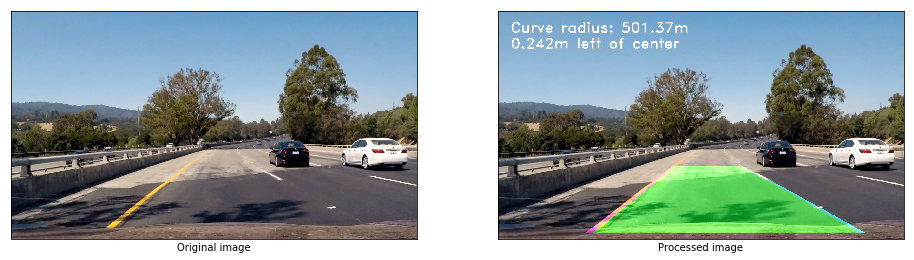

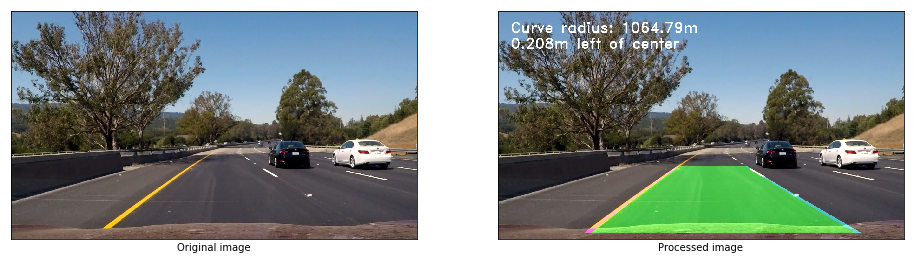

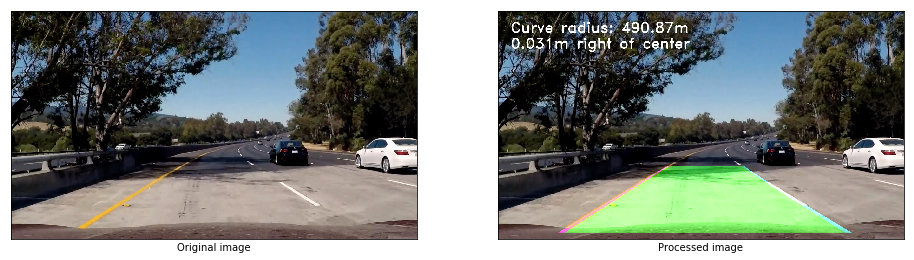

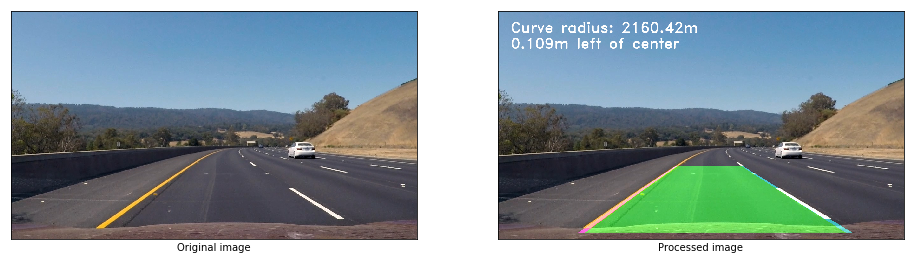

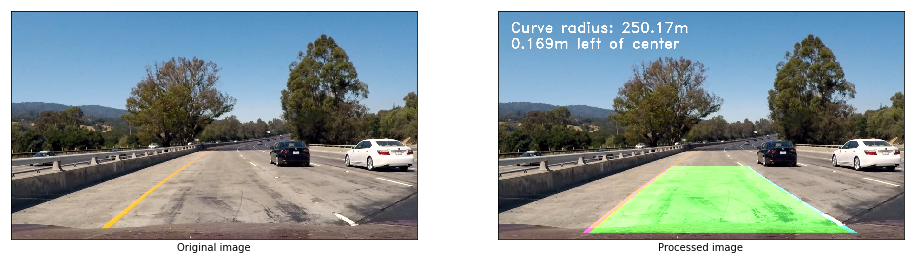

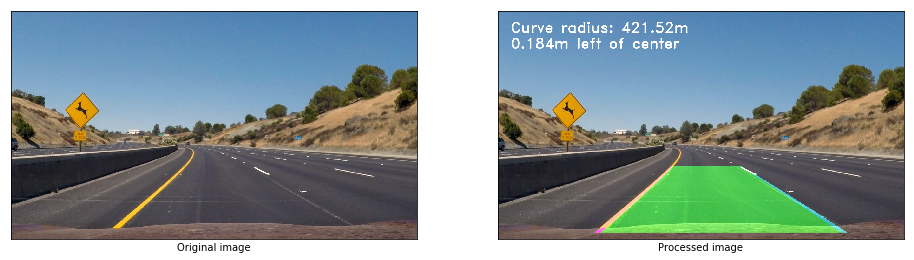

In [39]:
test_images_RGB = []

for fname in test_images:
    output_file_names.append(fname.split("/")[1])
    
output_file_names = []
count = 0
    
for original, processed in zip(test_images_RGB, binary_warped_images):
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = fit_polynomial(processed)
#     left_fit2, right_fit2, left_lane_inds, right_lane_inds = search_around_poly(processed, left_fit, right_fit)
    rad_l, rad_r, d_center = measure_curvature_real(
        processed,
        left_fit,
        right_fit,
        left_lane_inds,
        right_lane_inds,
    )
    result = draw(original, processed, left_fit, right_fit, Minv)
    result = write_data(result, (rad_l + rad_r) / 2, d_center)
    display(original, result, "Original image", "Processed image")
    mpimg.imsave('output_images/' + output_file_names[count], result, format='jpg')
    count += 1

## Video Processing

In [55]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
    
    RECENT_FITS = 10
    
    def add_fit(self, fit):
        self.detected = fit is not None
        if self.detected:
            self.current_fit.append(fit)
            if len(self.current_fit) > self.RECENT_FITS:
                self.current_fit = self.current_fit[len(self.current_fit) - self.RECENT_FITS:]
            self.best_fit = np.average(self.current_fit, axis=0)
        else:
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

In [58]:
def process_frame(img):
    undistorted = cal_undistort(img, matrix, distortion)
    threshold_image = apply_threshold(undistorted)
    warped, Minv = warp(threshold_image, matrix, distortion)
    
    l_fit, r_fit, l_lane_inds, r_lane_inds, _ = fit_polynomial(warped)
#     if l_line.detected and r_line.detected:
#         l_fit, r_fit, l_lane_inds, r_lane_inds = search_around_poly(warped, l_line.best_fit, r_line.best_fit)
#     else:
#         l_fit, r_fit, l_lane_inds, r_lane_inds, _ = fit_polynomial(warped)

    l_line.add_fit(l_fit)
    r_line.add_fit(r_fit)
    img_out1 = draw(undistorted, warped, l_fit, r_fit, Minv)
    rad_l, rad_r, d_center = measure_curvature_real(warped, l_fit, r_fit, l_lane_inds, r_lane_inds)
    return write_data(img_out1, (rad_l + rad_r) / 2, d_center)

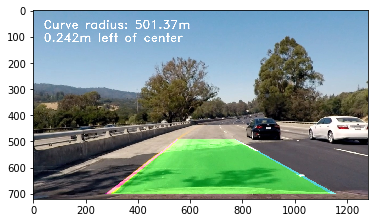

In [33]:
l_line = Line()
r_line = Line()

def test_process_frame(img):
    new_img = process_frame(img)
    plt.imshow(new_img)
    plt.show()
    
test_process_frame(test_images_RGB[0])

## Run on Video

In [62]:
l_line = Line()
r_line = Line()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'project_video_output.mp4'
start_second, end_second = 0, 10
clip1 = VideoFileClip("project_video.mp4").subclip(start_second, end_second)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 250/251 [01:03<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 35 s, sys: 4.37 s, total: 39.4 s
Wall time: 1min 6s


In [60]:
l_line = Line()
r_line = Line()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'challenge_video_output.mp4'
start_second, end_second = 0, 5
clip1 = VideoFileClip("challenge_video.mp4").subclip(start_second, end_second)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 150/150 [00:34<00:00,  3.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 20.6 s, sys: 1.29 s, total: 21.9 s
Wall time: 38.1 s


In [61]:
l_line = Line()
r_line = Line()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'harder_challenge_video_output.mp4'
start_second, end_second = 0, 5
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(start_second, end_second)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 99%|█████████▉| 125/126 [00:34<00:00,  3.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 20.6 s, sys: 1.48 s, total: 22.1 s
Wall time: 39 s
